# The Annotated Transformer

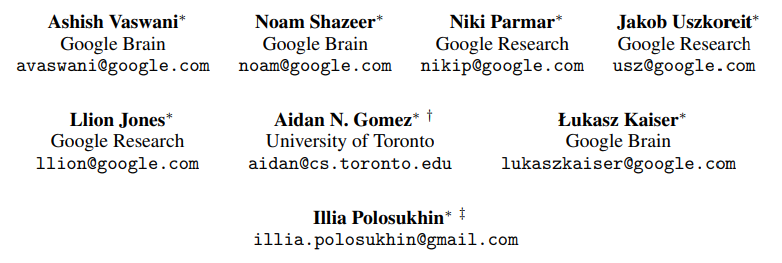

https://nlp.seas.harvard.edu/annotated-transformer/

Original: Sasha Rush

@SuhanZhang<br>mail:220242544@seu.edu.cn<br>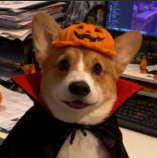<br>You can count on me with this!

## Dependency

In [4]:
# # Uncomment for colab
# #
# !pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [7]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


ImportError: cannot import name 'np_version_under1p18' from 'pandas.compat' (/mnt/disk1/suhan/STUDY/TheAnnotatedTransformer/.venv/lib/python3.10/site-packages/pandas/compat/__init__.py)

In [2]:
print(torch.cuda.is_available())

True


In [ ]:
# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [ ]:
# Some convenience helper functions used throughout the notebook


def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

## Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of which use convolutional neural networks as basic building block, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies between distant positions. In the Transformer this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention.

减少顺序计算的目标也是扩展神经 GPU、ByteNet 和 ConvS2S 的基础，它们都以卷积神经网络为基本构建模块，并行计算所有输入和输出位置的隐藏表示。在这些模型中，关联两个任意输入或输出位置的信号所需的运算次数会随着位置间距离的增加而增长，ConvS2S 呈线性增长，By​​teNet 呈对数增长。这使得学习远距离位置之间的依赖关系变得更加困难。在 Transformer 中，运算次数减少到恒定值，但代价是由于对注意力加权位置进行平均而降低了有效分辨率，我们通过多头注意力机制来抵消这种影响。

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. End-to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned recurrence and have been shown to perform well on simple-language question answering and language modeling tasks.

自注意力机制（有时也称为序列内注意力机制）是一种将单个序列的不同位置关联起来以计算序列表示的注意力机制。自注意力机制已成功应用于多种任务，包括阅读理解、抽象式文本摘要、文本蕴含以及学习与任务无关的句子表示。端到端记忆网络基于循环注意力机制而非序列对齐循环，并且已证明在简单语言问答和语言建模任务中表现良好。

To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution.

但据我们所知，Transformer 是第一个完全依靠自注意力机制来计算其输入和输出表示，而无需使用序列对齐的 RNN 或卷积的转换模型。

## Part1:Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure. Here, the encoder maps an input sequence of symbol representations $(x_1, \dots, x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, \dots, z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1, \dots, y_m)$ of symbols one element at a time. At each step the model is auto-regressive (cite), consuming the previously generated symbols as additional input when generating the next.

大多数具有竞争力的神经序列转换模型都采用编码器-解码器结构。其中，编码器将输入的符号表示序列 $(x_1, \dots, x_n)$ 映射到连续表示序列 $\mathbf{z} = (z_1, \dots, z_n)$。给定 $\mathbf{z}$，解码器将 $\mathbf{z}$ 映射到输出的符号序列 $(y_1, \dots, y_m)$。在每个步骤中，模型都是自回归的，在生成下一个符号时，会将先前生成的符号作为额外的输入。

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively.

Transformer 遵循这种整体架构，编码器和解码器分别采用堆叠式自注意力层和逐点全连接层，如图 1 的左半部分和右半部分所示。

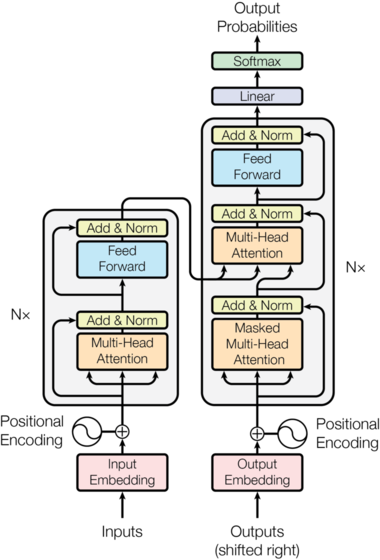